In [1]:
# Load the modules we're going to need
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import os
import glob
import librosa
import pandas as pd# Added
from IPython.display import Audio
from sklearn.externals import joblib
import mir_eval

In [2]:
# We've previously preprocessed our data and coverted all files to a sample rate of 44100
samplerate = 44100

In [3]:
# Specify where the audio files for training and testing reside
train_folder = './mir_class_train'
test_folder = './mir_class_test'

# Get a list of all the training audio files (must be .WAV files)
train_files = glob.glob(os.path.join(train_folder, '*.wav'))

# Get a list of all the test audio files (must be .WAV files)
test_files = glob.glob(os.path.join(test_folder, '*.wav'))

# Specify the labels (classes) we're going to classify the data into
label0 = 'abscent'
label1 = 'present'
labels = [label0, label1]

In [4]:
window_size = 2048
hop_size = 512
n_bands = 40
n_mfcc = 13
feature_length = 96
half_sec = 48

In [200]:
def print_labels(vec_orig, vec_calc, title):
    """ Receive two vocal/unvocal arrays with different size and plot them normalized"""
    orig = vec_orig.copy()
    orig[vec_orig>0] = 1.1
    orig[vec_orig<=0] = None

    calc = vec_calc.copy()
    calc[vec_calc>0] = 1
    calc[vec_calc<=0] = None
   
    x1 = np.linspace(0, 1, len(orig))
    x2 = np.linspace(0, 1, len(calc))
    
    plt.figure(figsize=(12,4))
   
    # Contar trechos vozeados
    for i in range(1,len(orig)-1):
        
        if orig[i] == 1.1 and orig[i-1] != 1.1:
            plt.axvline(x=x1[i], color='gray', linewidth=0.5)
        elif orig[i] == 1.1 and orig[i+1] != 1.1:
            plt.axvline(x=x1[i], color='gray', linewidth=0.5)

    plt.title(title)
    plt.ylim(ymax=2.1)  # adjust the max leaving min unchanged
    plt.ylim(ymin=0.0)  # adjust the min leaving max unchanged
    plt.yticks([])
    plt.plot(x1, orig, linewidth=6,solid_capstyle='butt', label='Original')
    plt.plot(x2, calc, linewidth=6, solid_capstyle='butt', label='Calculated')


### Predicting with MFCC (SVM)

In [156]:
# Test file name
tf = "../exp1/test/PortStWillow_StayEven_MIX.wav"

test_feat =[]
test_labels = []
print("filename: {:s}".format(os.path.basename(tf)))
    
# Load audio
audio, sr = librosa.load(tf, sr=samplerate, mono=True)

    # Extract mfcc coefficients (remember we will discard the first one)
    # To see all the relevant kwarg arugments consult the documentation for
    # librosa.feature.mfcc, librosa.feature.melspectrogram and librosa.filters.mel

mfcc = librosa.feature.mfcc(audio, sr=sr, n_fft=window_size, hop_length=hop_size,
                                fmax=samplerate/2, n_mels=n_bands, n_mfcc=(n_mfcc + 1))
          
    # Discard the first coefficient
mfcc = mfcc[1:,:]
    
print("mfcc shape", int(mfcc.shape[1]))
    
    # Read labels for each frame
f0line = pd.read_csv(tf[:-7]+"vocal.csv",index_col=None, header=None)
f0line = pd.DataFrame.as_matrix(f0line)
f0line = f0line.T[0]
    #timestamp = pd.DataFrame.as_matrix(f0line)[:,0]
    
    #print (mfcc.shape)
print("number of chunks", int(mfcc.shape[1]/half_sec))
    
feature_vector = []
tf_label = []
    
    # Delta features 
mfcc_delta = librosa.feature.delta(mfcc)
mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
    
    # For half second
for chunk in range(int(mfcc.shape[1]/half_sec)):
    start = chunk*half_sec
    mfcc_means = np.mean(mfcc[:,start:start+feature_length], 1)
    mfcc_stddevs = np.std(mfcc[:,start:start+feature_length], 1)
    mfcc_max = np.max(mfcc[:,start:start+feature_length], 1)
    mfcc_median = np.median(mfcc[:,start:start+feature_length], 1)
    mfcc_d1_means = np.mean(mfcc_delta[:,start:start+feature_length], 1)
    mfcc_d1_stddevs = np.std(mfcc_delta[:,start:start+feature_length], 1)
    mfcc_d2_means = np.mean(mfcc_delta2[:,start:start+feature_length], 1)
    mfcc_d2_stddevs = np.std(mfcc_delta2[:,start:start+feature_length], 1)
        
    
        # We could do the same for the delta features like this:
        # mfcc_d1_means = np.mean(np.diff(mfcc), 1)
        # mfcc_d1_stddevs = np.std(np.diff(mfcc), 1)
    
        # Concatenate means and std. dev's into a single feature vector
    feature_vector.append(np.concatenate((mfcc_means, mfcc_stddevs, mfcc_max, mfcc_median,\
                                              mfcc_d1_means, mfcc_d1_stddevs, mfcc_d2_means, mfcc_d2_stddevs\
                                             ), axis=0))
        #print("feature summary: {}".format(len(feature_vector)))
   
        # Adjust labels to our classes
    if len([x for x in f0line[start:start+feature_length] if x > 0]) >= 2*half_sec: # Get 100% of frames
        tf_label.append('present')
    else:
        tf_label.append('abscent')
       

# Get labels index
tf_label_ind = [labels.index(lbl) for lbl in tf_label]
print("file label size: {:d}".format(len(tf_label_ind)))
    
# Store the feature vector and corresponding label in integer format
for idx in range(len(feature_vector)):
    test_feat.append(feature_vector[idx])
    test_labels.append(tf_label_ind[idx]) 
print(" ")

filename: PortStWillow_StayEven_MIX.wav
mfcc shape 27306
number of chunks 568
file label size: 568
 


In [157]:
# some time later...
filename = '../finalized_model_SVM_0.1.sav' 
# load the model from disk
clf = joblib.load(filename)

filename = '../scaler.sav' 
# load the model from disk
scaler = joblib.load(filename)
#result = loaded_model.score(X_test, Y_test)
#print(result)

In [158]:
feat_scaler = scaler.transform(test_feat)
output = clf.predict(feat_scaler)
origin = test_labels

origin = np.array(origin)
output = np.array(output)

In [159]:
R, FA = mir_eval.melody.voicing_measures(origin, output)
print ("Recall", R, "False Alarme", FA)

Recall 0.854545454545 False Alarme 0.885245901639


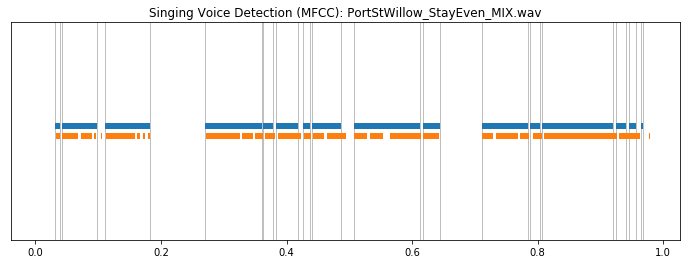

In [201]:
print_labels(np.array(origin).astype('float'), np.array(output).astype('float'),\
            'Singing Voice Detection (MFCC): '+os.path.basename(tf))

### Predicting with VGGish (SVM)

In [194]:
test_feat =[]
test_labels = []

print("filename: {:s}".format(os.path.basename(tf)))
   
# Load VGGish audio embeddings

vggish = pd.read_csv(tf[:-7]+"VGGish_PCA.csv",index_col=None, header=None)
vggish = pd.DataFrame.as_matrix(vggish)



# Read labels for each frame
f0line = pd.read_csv(tf[:-7]+"vocal.csv",index_col=None, header=None)
f0line = pd.DataFrame.as_matrix(f0line)
f0line = f0line.T[0][48:] # VGGish starts from 0
    

    
feature_vector = []
tf_label = []
    
print (vggish.shape[0])
    

for chunk in range(vggish.shape[0]): # if hop = 10ms then use: range(int(vggish.shape[0]/half_sec)):

    start = chunk*half_sec
    
    #vggish_means = np.mean(vggish[start:start+1, :], 0) # I removed the smooth to get only one window
    
    #vggish_stddevs = np.std(vggish[start:start+1, :], 0)
        #print (vggish_means.shape, start, start+feature_length)
    
        # Concatenate means and std. dev's into a single feature vector
        #feature_vector.append(np.concatenate((vggish_means, vggish_stddevs), axis=0))
    
    #if hop = 10ms then use:feature_vector.append(vggish[start, :][0])
    
    feature_vector.append(vggish[chunk, :])
        
        #print(feature_vector)
        
        # Adjust labels to our classes
    
    if len([x for x in f0line[start:start+feature_length] if x > 0]) >= half_sec: # 50%
    
        tf_label.append('present')
        
    else:
    
        tf_label.append('abscent')

    
    #Get labels index
tf_label_ind = np.array([labels.index(lbl) for lbl in tf_label])
print("file label size: {}".format(tf_label_ind.shape))
    
    
    # Store the feature vector and corresponding label in integer format

for idx in range(len(feature_vector)):

    test_feat.append(feature_vector[idx])
    test_labels.append(tf_label_ind[idx])
print(" ")

filename: PortStWillow_StayEven_MIX.wav
659
file label size: (659,)
 


In [195]:
# some time later...
filename = '../finalized_model_SVM_0.1_VGGish.sav' 
# load the model from disk
clf2 = joblib.load(filename)

filename = '../scaler_VGGish.sav' 
# load the model from disk
scaler = joblib.load(filename)
#result = loaded_model.score(X_test, Y_test)
#print(result)

In [196]:
feat_scaler = scaler.transform(test_feat)
output = clf2.predict(feat_scaler)
origin = test_labels

In [197]:
origin = np.array(origin)
output = np.array(output)

In [198]:
R, FA = mir_eval.melody.voicing_measures(origin, output)
print ("Recall", R, "False Alarme", FA)

Recall 0.911392405063 False Alarme 0.189189189189


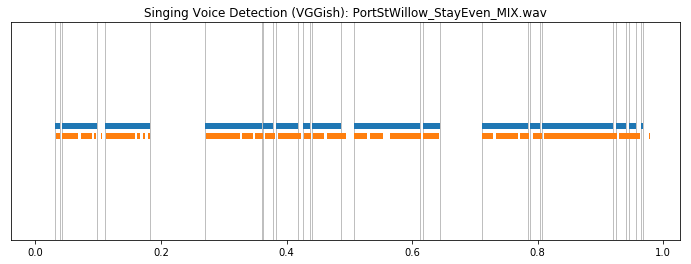

In [202]:
print_labels(np.array(origin).astype('float'), np.array(output).astype('float'), \
             'Singing Voice Detection (VGGish): '+os.path.basename(tf))

In [122]:
import vad_cls

# EVALUATE
evaluation = vad_cls.evaluate_results(origin, output)
print (evaluation)

ImportError: No module named 'vad_cls'